Gevorning equations ([Radko, 2016](https://doi.org/10.1017/jfm.2016.547)):
\begin{align}
    \nabla\cdot \boldsymbol{u} &= 0,\\
    \partial_t \boldsymbol{u} + U_{bg}\partial_x\boldsymbol{u} + w\partial_z U_{bg}\boldsymbol{e}_x + \boldsymbol{u}\cdot\nabla\boldsymbol{u} &= -\nabla p + \frac{Pr}{Pe}\nabla^2\boldsymbol{u} + \frac{4\pi^2 Ri}{R_\rho-1}(T-S)\boldsymbol{e}_z,\\
    \partial_t T + U_{bg}\partial_x T + \boldsymbol{u}\cdot\nabla T - w &= \frac{1}{Pe}\nabla^2 T,\\
    \partial_t S + U_{bg}\partial_x S + \boldsymbol{u}\cdot\nabla S - R_\rho w &= \frac{\tau}{Pe}\nabla^2 S.
\end{align}
where $U_{bg}=sin(2\pi z)$,

For example, with 3D configuration, these governing equations can be expressed as follows
\begin{align}
    \nabla\cdot \boldsymbol{u} &= 0,\\
    \partial_t u + sin(2\pi z)\partial_x u +2\pi cos(2\pi z)w+ u\cdot\nabla u &= -\partial_x p + \frac{Pr}{Pe}\nabla^2u ,\\
    \partial_t v + sin(2\pi z)\partial_x v + v\cdot\nabla v &= -\partial_y p + \frac{Pr}{Pe}\nabla^2v ,\\
    \partial_t w + sin(2\pi z)\partial_x w + w\cdot\nabla w &= -\partial_z p + \frac{Pr}{Pe}\nabla^2w + \frac{4\pi^2 Ri}{R_\rho-1}(T-S),\\
    \partial_t T + sin(2\pi z)\partial_x T + \boldsymbol{u}\cdot\nabla T - w &= \frac{1}{Pe}\nabla^2 T,\\
    \partial_t S + sin(2\pi z)\partial_x S + \boldsymbol{u}\cdot\nabla S - R_\rho w &= \frac{\tau}{Pe}\nabla^2 S.
\end{align}

In [49]:
'''
Dedalus script to simulate thermohaline-shear equations in 2D periodic domain.
um, wm, Tm, Sm: <u>, <w>, <T>, <S> (<.> is horizontally averaged variable)
up, wp, Tp, Sp: u', w', T', S'

Parameters: 
Pr (Prandtl), 
tau (diffusivity ratio), 
Rp (R_rho, diffusive density ratio), 
Pe (Peclet)

To run, restart, and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 fluc.py
    $ mpiexec -n 4 python3 fluc.py --restart
'''
import sys
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import math
import h5py
import logging
logger = logging.getLogger(__name__)

# Allow restarting via command line
restart = (len(sys.argv) > 1 and sys.argv[1] == '--restart')

dealias = 3/2 
pi = np.pi
Rp, Ri, Pe, tau = 2., 10., 1e2, 0.01 # figure 4
Pr = 10.  # Prandtl number
Lx, Lz = 64., 1.
Nx, Nz = 384, 192
stop_sim_time = 100 + 300*restart # Stopping criteria
# Bases
coords = d3.CartesianCoordinates('x','z')
dist = d3.Distributor(coords, dtype=np.float64)
# define the coordinate system
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.RealFourier(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

Now, we decompose perturbations of velocity, pressure, temperature, and salinity fields into two components: mean and fluctuation quantities.
\begin{align}
    \boldsymbol{u} &= \bar{\boldsymbol{u}}+\boldsymbol{u}'\\
    p &= \bar{p}+p',\\
    T &= \bar{T}+T',\\
    S &= \bar{S}+S'.
\end{align}

Based on this, we have horizontally averaged quantities
$$
<\boldsymbol{u}>_h=\bar{\boldsymbol{u}}(z), \quad <\bar{T}>_h=\bar{T}(z), \quad <\bar{S}>_h=\bar{S}(z), \\
<\boldsymbol{u}'>_h=0, \quad <T'>_h=0, \quad <S'>_h=0,
$$
where $<.>_h = \frac{1}{L_x L_y}\int<.>dxdy$

Then, we have
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{u}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{u}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h  \neq 0 ,
$$
and 
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{T}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{T}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{T}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{T}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{T}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{T}'>_h  \neq 0 ,
$$
and 
$$
\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{S}} = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{S}}>_h = <\boldsymbol{u}'>_h\cdot\nabla\boldsymbol{\bar{S}} = 0,\\
<\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{S}'>_h = \boldsymbol{\bar{u}}\cdot\nabla<\boldsymbol{S}'>_h = 0,\\
<\boldsymbol{u}'\cdot\nabla\boldsymbol{S}'>_h  \neq 0 ,
$$

In [50]:
# define fields
# um, wm, pm, Tm, Sm: <u>, <w>, <p>, <T>, <S> (<.> is horizontally averaged variable)
# up, wp, pp, Tp, Sp:  u',  w',  p',  T',  S'
pm = dist.Field(name='pm', bases=(zbasis)) # horizontally averaged pressure
pp = dist.Field(name='pp', bases=(xbasis,zbasis)) # pressure fluctuation
um = dist.VectorField(coords,name='um', bases=(zbasis)) # horizontally averaged u(z)
up = dist.VectorField(coords,name='up', bases=(xbasis,zbasis)) # fluctuation u'(x,z)
Sm = dist.Field(name='Sm', bases=(zbasis)) # horizontally averaged S(z)
Sp = dist.Field(name='Sp', bases=(xbasis,zbasis)) # fluctuation S'(x,z)
Tm = dist.Field(name='Tm', bases=(zbasis)) # horizontally averaged T(z)
Tp = dist.Field(name='Tp', bases=(xbasis,zbasis)) # fluctuation T'(x,z)
Ubg = dist.Field(bases=(zbasis)) #background velocity of basic state

# Substitutions
x, z = dist.local_grids(xbasis, zbasis) # get coordinate arrays in horizontal and vertical directions
ex, ez = coords.unit_vector_fields(dist) # get unit vectors in horizontal and vertical directions
# define velocity components
U = um + up # full velocity
T = Tm + Tp # full temperature
S = Sm + Sp # full salinity
Rho = (S-T)+(1-Rp)*z # density
Rhom = (Sm-Tm)+(1-Rp)*z # horizontally averaged density
# create constant sub-field for incompressible flow condition's equation
tau_pm = dist.Field(name='tau_pm') 
tau_pp = dist.Field(name='tau_pp') 
# because this term is only a contant added to the equation, we don't need to instantiate it for bases system

# First-order form: "div(A)" becomes "trace(grad_A)"
lap = lambda A: d3.div(d3.grad(A)) # First-order form: "lap(f)" becomes "div(grad_f)"
dx = lambda A: d3.Differentiate(A, coords['x']) 
dz = lambda A: d3.Differentiate(A, coords['z'])
vol_avg = lambda A: d3.Average(A) # Horizontal mean of A 
h_mean = lambda A: d3.Average(A,'x') # Horizontal mean of A

Ubg['g'] = np.sin(2*pi*z)

# Problem
problem = d3.IVP([pm,pp,tau_pm, tau_pp,
                  um,up,
                  Tm,Tp, 
                  Sm,Sp], namespace=locals())

The continuous equation can be held in form of full velocity
\begin{equation}
    \nabla\cdot (\boldsymbol{\bar{u}}+\boldsymbol{u}') = 0 \Leftrightarrow \nabla\cdot\boldsymbol{\bar{u}}+\nabla\cdot\boldsymbol{u}' = 0.
\end{equation}
then
\begin{align}
    <\nabla\cdot\boldsymbol{\bar{u}}+\nabla\cdot\boldsymbol{u}'>_h = \nabla\cdot\boldsymbol{\bar{u}} &= 0, \quad\Leftrightarrow \partial_x \bar{u}+\partial_z \bar{w}=0, \quad\Leftrightarrow \partial_z \bar{w}=0,\\
    \nabla\cdot\boldsymbol{u}' &= 0,
\end{align}

In [51]:
problem.add_equation("trace(grad(um))+tau_pm = 0")
problem.add_equation("trace(grad(up))+tau_pp = 0")
problem.add_equation("integ(pm) = 0") # Pressure gauge
problem.add_equation("integ(pp) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(<Field 140347152986816>)),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(<Field 140347152986816>)),
 'F': <Field 140347149777568>,
 'domain': <dedalus.core.domain.Domain at 0x7fa52424a0c0>,
 'matrix_dependence': array([ True,  True]),
 'matrix_coupling': array([False, False])}

The momentum equation can becomes
\begin{align}
    \partial_t (\boldsymbol{\bar{u}}+\boldsymbol{u}') + U_{bg}\partial_x(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \partial_z U_{bg} (\bar{w}+w')\boldsymbol{e}_x + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla(\boldsymbol{\bar{u}}+\boldsymbol{u}') &= -\nabla (\bar{p}+p') + \frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}+T')-(\bar{S}+S'))\boldsymbol{e}_z,\\
\Leftrightarrow 
    \partial_t (\boldsymbol{\bar{u}}+\boldsymbol{u}')+ U_{bg}\partial_x\boldsymbol{u}' + \partial_z U_{bg}w'\boldsymbol{e}_x
    + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}' + \boldsymbol{u}'\cdot\nabla\boldsymbol{u}'
    &= -\nabla (\bar{p}+p') + \frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}') + \frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}-\bar{S})+(T'-S'))\boldsymbol{e}_z,\\
\end{align}

then we horizontally average this equation, and get
$$
    <\partial_t (\boldsymbol{\bar{u}}+\vec{u}')>_h
    + <U_{bg}\partial_x\boldsymbol{u}'>_h + <\partial_z U_{bg}w'\boldsymbol{e}_x>_h
    + <\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{\bar{u}}>_h + <\boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}}>_h + <\boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}'>_h + <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h\\
    = -<\nabla (\bar{p}+p')>_h + <\frac{Pr}{Pe}\nabla^2(\boldsymbol{\bar{u}}+\boldsymbol{u}')>_h + <\frac{4\pi^2 Ri}{R_\rho-1}((\bar{T}-\bar{S})+(T'-S'))\boldsymbol{e}_z>_h,\\
\Leftrightarrow 
    \partial_t \boldsymbol{\bar{u}}
    + <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h
    = -\nabla\bar{p} + \frac{Pr}{Pe}\nabla^2\boldsymbol{\bar{u}} + \frac{4\pi^2 Ri}{R_\rho-1}(\bar{T}-\bar{S})\boldsymbol{e}_z ,
$$
This equation can be called equation of the horizontally averaged velocity component

Now, we can take the equation of fluctuation = the original momentum equation - horizontally averaged equation
$$
    \partial_t \boldsymbol{u}'+ U_{bg}\partial_x\boldsymbol{u}' + \partial_z U_{bg}w'\boldsymbol{e}_x
    + \boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}' + \boldsymbol{u}'\cdot\nabla\boldsymbol{u}'
    - <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h
    = -\nabla p' + \frac{Pr}{Pe}\nabla^2\boldsymbol{u}' + \frac{4\pi^2 Ri}{R_\rho-1}(T'-S')\boldsymbol{e}_z,
$$

And,
$$
<\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h 
= <\begin{bmatrix}
    \boldsymbol{u}'\cdot\nabla u' \\
    \boldsymbol{u}'\cdot\nabla v' \\
    \boldsymbol{u}'\cdot\nabla w'
  \end{bmatrix}>_h 
= <\begin{bmatrix}
    u'\partial_x u'+v'\partial_y u'+w'\partial_z u'\\
    u'\partial_x v'+v'\partial_y v'+w'\partial_z v'\\
    u'\partial_x w'+v'\partial_y w'+w'\partial_z w'
  \end{bmatrix}>_h 
= \begin{bmatrix}
    <u'\partial_x u'+v'\partial_y u'+w'\partial_z u'>_h \\
    <u'\partial_x v'+v'\partial_y v'+w'\partial_z v'>_h \\
    <u'\partial_x w'+v'\partial_y w'+w'\partial_z w'>_h 
  \end{bmatrix}\\
= \begin{bmatrix}
    <[\partial_x (u'u')-(\partial_x u')u']+[\partial_y (v'u')-\partial_y (v')u']+[\partial_z (w'u')-(\partial_z w')u']>_h \\
    <[\partial_x (u'v')-(\partial_x u')v']+[\partial_y (v'v')-\partial_y (v')v']+[\partial_z (w'v')-(\partial_z w')v']>_h \\
    <[\partial_x (u'w')-(\partial_x u')w']+[\partial_y (v'w')-\partial_y (v')w']+[\partial_z (w'w')-(\partial_z w')w']>_h 
  \end{bmatrix}\\
= \begin{bmatrix}
    <[\partial_x (u'u')+\partial_y (v'u')+\partial_z (w'u')]-[\partial_x u'+\partial_y v'+\partial_z w']u'>_h \\
    <[\partial_x (u'v')+\partial_y (v'v')+\partial_z (w'v')]-[\partial_x u'+\partial_y v'+\partial_z w']v'>_h \\
    <[\partial_x (u'w')+\partial_y (v'w')+\partial_z (w'w')]-[\partial_x u'+\partial_y v'+\partial_z w']w'>_h 
  \end{bmatrix}\\
= \begin{bmatrix}
    <\partial_x (u'u')+\partial_y (v'u')+\partial_z (w'u')>_h \\
    <\partial_x (u'v')+\partial_y (v'v')+\partial_z (w'v')>_h \\
    <\partial_x (u'w')+\partial_y (v'w')+\partial_z (w'w')>_h 
  \end{bmatrix}\\
= \begin{bmatrix}
    <\partial_z (w'u')>_h \\
    <\partial_z (w'v')>_h \\
    <\partial_z (w'w')>_h 
  \end{bmatrix}\\
\Leftrightarrow 
  <\boldsymbol{u}'\cdot\nabla\boldsymbol{u}'>_h = <\partial_z (w'\boldsymbol{u}')>_h
$$

Then, we have
\begin{align}
    \partial_t \boldsymbol{\bar{u}}
    + <\partial_z (w'\boldsymbol{u}')>_h
    = -\nabla\bar{p} + \frac{Pr}{Pe}\nabla^2\boldsymbol{\bar{u}} + \frac{4\pi^2 Ri}{R_\rho-1}(\bar{T}-\bar{S})\boldsymbol{e}_z,\\
    \partial_t \boldsymbol{u}'+ U_{bg}\partial_x\boldsymbol{u}' + \partial_z U_{bg}w'\boldsymbol{e}_x
    + \boldsymbol{u}'\cdot\nabla\boldsymbol{\bar{u}} + \boldsymbol{\bar{u}}\cdot\nabla\boldsymbol{u}' + \boldsymbol{u}'\cdot\nabla\boldsymbol{u}'
    - <\partial_z (w'\boldsymbol{u}')>_h
    = -\nabla p' + \frac{Pr}{Pe}\nabla^2\boldsymbol{u}' + \frac{4\pi^2 Ri}{R_\rho-1}(T'-S')\boldsymbol{e}_z,
\end{align}

In [52]:
problem.add_equation("dt(um) + grad(pm) - (Pr/Pe)*lap(um) - (4*pi*pi*Ri/(Rp-1))*(Tm-Sm)*ez = - dz(h_mean(up@ez*up))")
problem.add_equation("dt(up) + Ubg*dx(up) + up@ez*dz(Ubg)*ex + grad(pp) - (Pr/Pe)*lap(up) - (4*pi*pi*Ri/(Rp-1))*(Tp-Sp)*ez = - up@grad(um)-um@grad(up)-up@grad(up)+dz(h_mean(up@ez*up))")

{'LHS': Add(Add(Add(Add(Add(dt(<Field 140347251351648>), Mul(<Field 140347252712672>, Diff(<Field 140347251351648>))), Mul(Mul(Dot(<Field 140347251351648>, <Field 140347252715120>), Diff(<Field 140347252712672>)), <Field 140347252718672>)), Grad(<Field 140347152986816>)), Mul(-1, Mul(0.1, Div(Grad(<Field 140347251351648>))))), Mul(-1, Mul(Mul(394.78417604357435, Add(<Field 140347252716080>, Mul(-1, <Field 140347155089840>))), <Field 140347252715120>))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140347251351648>), Grad(<Field 140347153882416>)), Mul(-1, Dot(<Field 140347153882416>, Grad(<Field 140347251351648>)))), Mul(-1, Dot(<Field 140347251351648>, Grad(<Field 140347251351648>)))), Convert(Diff(Average(Mul(Dot(<Field 140347251351648>, <Field 140347252715120>), <Field 140347251351648>))))),
 'condition': 'True',
 'tensorsig': (<dedalus.core.coords.CartesianCoordinates at 0x7fa53199eab0>,),
 'dtype': dtype('float64'),
 'M': <Field 140347251351648>,
 'L': Add(Add(Add(Add(Mul(<Field 1403472

The temperature equation:
\begin{align}
    \partial_t (\bar{T}+T') + U_{bg}\partial_x (\bar{T}+T') + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla (\bar{T}+T') - (\bar{w}+w') &= \frac{1}{Pe}\nabla^2 (\bar{T}+T'),\\
\Leftrightarrow 
    \partial_t (\bar{T}+T') + U_{bg}\partial_x T' + \boldsymbol{\bar{u}}\cdot\nabla\bar{T} + \boldsymbol{u}'\cdot\nabla\bar{T} + \boldsymbol{\bar{u}}\cdot\nabla T' + \boldsymbol{u}'\cdot\nabla T'
    - w' &= \frac{1}{Pe}\nabla^2 (\bar{T}+T'),
\end{align}


By using the same maner, we horizontal average above equation, and can get
$$
    \partial_t \bar{T} + <\boldsymbol{u}'\cdot\nabla T'>_h = \frac{1}{Pe}\nabla^2 \bar{T} = \frac{1}{Pe}\partial_z^2 \bar{T},
$$
then
$$
\partial_t T'  + U_{bg}\partial_x T' + \boldsymbol{u}'\cdot\nabla\bar{T} + \boldsymbol{\bar{u}}\cdot\nabla T' + \boldsymbol{u}'\cdot\nabla T' - <\boldsymbol{u}'\cdot\nabla T'>_h - w' = \frac{1}{Pe}\nabla^2 T',
$$

due to $\boldsymbol{\bar{u}}\cdot\nabla\bar{T}=0$

And,
$$
<\boldsymbol{u}'\cdot\nabla T'>_h = <\partial_z (w'T')>_h
$$

Then, we have
\begin{align}
    \partial_t \bar{T} + <\partial_z (w'T')>_h = \frac{1}{Pe}\partial_z^2 \bar{T},\\
    \partial_t T' + U_{bg}\partial_x T' + \boldsymbol{u}'\cdot\nabla\bar{T} + \boldsymbol{\bar{u}}\cdot\nabla T' + \boldsymbol{u}'\cdot\nabla T' - <\partial_z (w'T')>_h - w' = \frac{1}{Pe}\nabla^2 T',
\end{align}

In [53]:
problem.add_equation("dt(Tm)              - (1./Pe)*dz(dz(Tm))      = - dz(h_mean(up@ez*Tp))")
problem.add_equation("dt(Tp) + Ubg*dx(Tp) - (1./Pe)*lap(Tp) - up@ez = - up@grad(Tm)-um@grad(Tp)-up@grad(Tp)+dz(h_mean(up@ez*Tp))")

{'LHS': Add(Add(Add(dt(<Field 140347252716080>), Mul(<Field 140347252712672>, Diff(<Field 140347252716080>))), Mul(-1, Mul(0.01, Div(Grad(<Field 140347252716080>))))), Mul(-1, Dot(<Field 140347251351648>, <Field 140347252715120>))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140347251351648>), Grad(<Field 140347252718864>)), Mul(-1, Dot(<Field 140347153882416>, Grad(<Field 140347252716080>)))), Mul(-1, Dot(<Field 140347251351648>, Grad(<Field 140347252716080>)))), Convert(Diff(Average(Mul(Dot(<Field 140347251351648>, <Field 140347252715120>), <Field 140347252716080>))))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': <Field 140347252716080>,
 'L': Add(Add(Mul(<Field 140347252712672>, Diff(<Field 140347252716080>)), Mul(-1, Mul(0.01, Div(Grad(<Field 140347252716080>))))), Mul(-1, Dot(<Field 140347251351648>, <Field 140347252715120>))),
 'F': Add(Add(Add(Dot(Mul(-1, <Field 140347251351648>), Grad(<Field 140347252718864>)), Mul(-1, Dot(<Field 140347153882416>, Grad

The sanility equation:
\begin{align}
    \partial_t (\bar{S}+S') + U_{bg}\partial_x (\bar{S}+S') + (\boldsymbol{\bar{u}}+\boldsymbol{u}')\cdot\nabla (\bar{S}+S') - R_\rho (\bar{w}+w') &= \frac{\tau}{Pe}\nabla^2 (\bar{S}+S'),\\
\Leftrightarrow 
    \partial_t (\bar{S}+S') + U_{bg}\partial_x S' + \boldsymbol{\bar{u}}\cdot\nabla\bar{S} + \boldsymbol{u}'\cdot\nabla\bar{S} + \boldsymbol{\bar{u}}\cdot\nabla S' + \boldsymbol{u}'\cdot\nabla S' - R_\rho w' &= \frac{\tau}{Pe}\nabla^2 (\bar{S}+S'),
\end{align}
then
\begin{align}
    \partial_t \bar{S} + <\boldsymbol{u}'\cdot\nabla S'>_h &= \frac{\tau}{Pe}\nabla^2 \bar{S}=  \frac{\tau}{Pe}\partial_z^2 \bar{S}, \\
    \partial_t S' + \boldsymbol{u}'\cdot\nabla\bar{S} + \boldsymbol{\bar{u}}\cdot\nabla S' + \boldsymbol{u}'\cdot\nabla S' - <\boldsymbol{u}'\cdot\nabla S'>_h - R_\rho w' &= \frac{\tau}{Pe}\nabla^2 S',
\end{align}
due to $\boldsymbol{\bar{u}}\cdot\nabla\bar{S}=0$

And,
$$
<\boldsymbol{u}'\cdot\nabla S'>_h = <\partial_z (w'S')>_h
$$

Then, we have
\begin{align}
    \partial_t \bar{S} + <\partial_z (w'S')>_h &= \frac{\tau}{Pe}\partial_z^2 \bar{S}, \\
    \partial_t S' + U_{bg}\partial_x S' + \boldsymbol{u}'\cdot\nabla\bar{S} + \boldsymbol{\bar{u}}\cdot\nabla S' + \boldsymbol{u}'\cdot\nabla S' - <\partial_z (w'S')>_h - R_\rho w' &= \frac{\tau}{Pe}\nabla^2 S',
\end{align}

In [54]:
problem.add_equation("dt(Sm)              - (tau/Pe)*dz(dz(Sm))           = - dz(h_mean((up@ez)*Sp))")
problem.add_equation("dt(Sp) + Ubg*dx(Sp) - (tau/Pe)*lap(Sp) - Rp*(up@ez) = - up@grad(Sm)-um@grad(Sp)-up@grad(Sp)+dz(h_mean((up@ez)*Sp))")

{'LHS': Add(Add(Add(dt(<Field 140347155089840>), Mul(<Field 140347252712672>, Diff(<Field 140347155089840>))), Mul(-1, Mul(0.0001, Div(Grad(<Field 140347155089840>))))), Mul(-1, Mul(2.0, Dot(<Field 140347251351648>, <Field 140347252715120>)))),
 'RHS': Add(Add(Add(Dot(Mul(-1, <Field 140347251351648>), Grad(<Field 140347251375328>)), Mul(-1, Dot(<Field 140347153882416>, Grad(<Field 140347155089840>)))), Mul(-1, Dot(<Field 140347251351648>, Grad(<Field 140347155089840>)))), Convert(Diff(Average(Mul(Dot(<Field 140347251351648>, <Field 140347252715120>), <Field 140347155089840>))))),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('float64'),
 'M': <Field 140347155089840>,
 'L': Add(Add(Mul(<Field 140347252712672>, Diff(<Field 140347155089840>)), Mul(-1, Mul(0.0001, Div(Grad(<Field 140347155089840>))))), Mul(-1, Mul(2.0, Dot(<Field 140347251351648>, <Field 140347252715120>)))),
 'F': Add(Add(Add(Dot(Mul(-1, <Field 140347251351648>), Grad(<Field 140347251375328>)), Mul(-1, Dot(<Fiel

In [55]:
# timestepper = d3.RK443
timestepper = d3.RK222

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
if not restart:
    # pm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    pp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    # um.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    up.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    # Tm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Tp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    # Sm.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    Sp.fill_random('g', seed=42, distribution='normal', scale=1e-4) # Random noise
    file_handler_mode = 'overwrite'
    initial_timestep = 0.02
    max_timestep = 0.02
else:
    write, initial_timestep = solver.load_state('/home/jms24002/reproduce_radko_results/fig5/checkpoints/checkpoints_s90.h5')
    max_timestep = 0.02
    file_handler_mode = 'append'
    logger.info('Imported last-step data successfully')


2024-09-30 18:19:33,801 subsystems 0/1 INFO :: Building subproblem matrices 1/192 (~1%) Elapsed: 0s, Remaining: 5s, Rate: 4.0e+01/s
2024-09-30 18:19:34,152 subsystems 0/1 INFO :: Building subproblem matrices 20/192 (~10%) Elapsed: 0s, Remaining: 3s, Rate: 5.3e+01/s
2024-09-30 18:19:34,526 subsystems 0/1 INFO :: Building subproblem matrices 40/192 (~21%) Elapsed: 1s, Remaining: 3s, Rate: 5.3e+01/s
2024-09-30 18:19:34,893 subsystems 0/1 INFO :: Building subproblem matrices 60/192 (~31%) Elapsed: 1s, Remaining: 2s, Rate: 5.4e+01/s
2024-09-30 18:19:35,263 subsystems 0/1 INFO :: Building subproblem matrices 80/192 (~42%) Elapsed: 1s, Remaining: 2s, Rate: 5.4e+01/s
2024-09-30 18:19:35,634 subsystems 0/1 INFO :: Building subproblem matrices 100/192 (~52%) Elapsed: 2s, Remaining: 2s, Rate: 5.4e+01/s
2024-09-30 18:19:36,010 subsystems 0/1 INFO :: Building subproblem matrices 120/192 (~62%) Elapsed: 2s, Remaining: 1s, Rate: 5.4e+01/s
2024-09-30 18:19:36,399 subsystems 0/1 INFO :: Building subpro

Save data to analyze later. 
1. Saved instantaneous fields include:
- horizontally averaged velocity: $\langle\boldsymbol{u}\rangle_h$,velocity fluctuation: $\boldsymbol{u}'$, 
- horizontally averaged temperature: $\langle T\rangle_h$, temperature fluctuation: $T'$, 
- horizontally averaged sanility: $\langle S\rangle_h$, sanility fluctuation: $S'$, 
- horizontally averaged pressure: $\langle p\rangle_h$, pressure fluctuation: $p'$, 
- vorticity: $\nabla\times\boldsymbol{u}$, 
- Nusselt numbers (scaled global salt/heat transfer rates): $Nu_S=\frac{\langle u_z S\rangle_a}{\kappa_S \Delta_S H^{-1}}$ and $Nu_T=\frac{\langle u_z T\rangle_a}{\kappa_T \Delta_T H^{-1}}$
- Reynolds numbers: $Re_i=\frac{u_i^{rms}H}{\nu}$ with $i$ representing $x,y,z$
- convective density flux: $-\langle u_z \rho'\rangle_a$
- scalar gradients: $\langle \partial_z\zeta \rangle_h$
- scalar convective fluxes: $\langle u_z \zeta \rangle_h$
- turbulent diffusivity: $\kappa_\zeta^T = \langle u_z \zeta \rangle_h / \langle \partial_z\zeta \rangle_h$
2. Saved time-averaged profiles include:
- Time-averaged temperature: $\bar{T}$
- Time-averaged sanility: $\bar{S}$
- Time-averaged density: $\bar{\rho'}$
- Time-averaged temperature's convective flux: $\overline{u_z T}$
- Time-averaged sanility's convective flux: $\overline{u_z S}$
- Time-averaged density's convective flux: $-\overline{u_z \rho}$
- Total flux ratio: $\gamma^*(z) = \frac{\beta_S \left( \langle W_{\text{dim}} S_{\text{dim}} \rangle_h + \kappa_S \partial_z \langle S \rangle_h \right)}{\beta_T \left( \langle W_{\text{dim}} \theta_{\text{dim}} \rangle_h + \kappa_T \partial_z \langle T_{\text{dim}} \rangle_h \right)},$

In [56]:
# store instantaneous data for analysis later
# first, we save horizontal averaged fields (1D array) following small output time-step
timehistory = solver.evaluator.add_file_handler('timehistory', sim_dt=1.0, max_writes=10000, mode=file_handler_mode)
timehistory.add_task(um@ex, name='um') # horizontal averaged x-axis velocity
timehistory.add_task(um@ez, name='wm') # horizontal averaged z-axis velocity, optional, becasue wm=0
timehistory.add_task(Tm, name='Tm') # horizontal averaged temperature
timehistory.add_task(Sm, name='Sm') # horizontal averaged sanility
timehistory.add_task(Rhom, name='Rhom') # horizontal averaged density
timehistory.add_task(dz(Sm), name='S_grad') # horizontally averaged profiles of scalar gradients
timehistory.add_task(dz(Tm), name='T_grad')
timehistory.add_task(dz(Rhom), name='Den_grad')
timehistory.add_task(h_mean(U@ez*S), name='S_conv_flux') # horizontally averaged profiles of scalar convective fluxes
timehistory.add_task(h_mean(U@ez*T), name='T_conv_flux')
timehistory.add_task(h_mean(U@ez*S)/dz(Sm), name='S_tur_diff') # horizontally averaged profiles of turbulent diffusivity
timehistory.add_task(h_mean(U@ez*T)/dz(Tm), name='T_tur_diff')
timehistory.add_task(h_mean(U@ez*Rho)/dz(Rhom), name='den_tur_diff')

# timehistory.add_task(vol_avg((U@ez)*S)/(KS*dT/Lz), name='nusselt_s')
# timehistory.add_task(vol_avg((U@ez)*S)/(KT*dT/Lz), name='nusselt_t')
# timehistory.add_task(up@ex*up@ex*Lz/nu, name='Re_x')
# timehistory.add_task(up@ez*up@ez*Lz/nu, name='Re_z')
timehistory.add_task(-vol_avg(U@ez*Rho), name='conv_den_flux')

# second, we save horizontal averaged fields (1D array) and coressponding pluctuation fields (2D array) following higher output time-step  
# this can help us to construct full fields for preocessing later
snapshot = solver.evaluator.add_file_handler('snapshots', sim_dt=50.0, max_writes=10000, mode=file_handler_mode)
snapshot.add_task(um@ex, name='um')
snapshot.add_task(um@ez, name='wm') #optional, becasue wm=0
snapshot.add_task(up@ex, name='up')
snapshot.add_task(up@ez, name='wp')
snapshot.add_task(Tm, name='Tm')
snapshot.add_task(Tp, name='Tp')
snapshot.add_task(Sm, name='Sm')
snapshot.add_task(Sp, name='Sp')
snapshot.add_task(pm+pp, name='p')
snapshot.add_task(Rho, name='Rho')
snapshot.add_task(-d3.div(d3.skew(um+up)), name='vorticity')

In [58]:
# store data of last-step snapshot for restarting
# checkpoints = solver.evaluator.add_file_handler('checkpoints', sim_dt=100, max_writes=1, mode=file_handler_mode)
# checkpoints.add_tasks(solver.state)

2024-09-30 18:19:37,477 __main__ 0/1 INFO :: Starting main loop
2024-09-30 18:19:38,295 __main__ 0/1 INFO :: Completed iteration 1, time=0.020, dt=0.0200000000


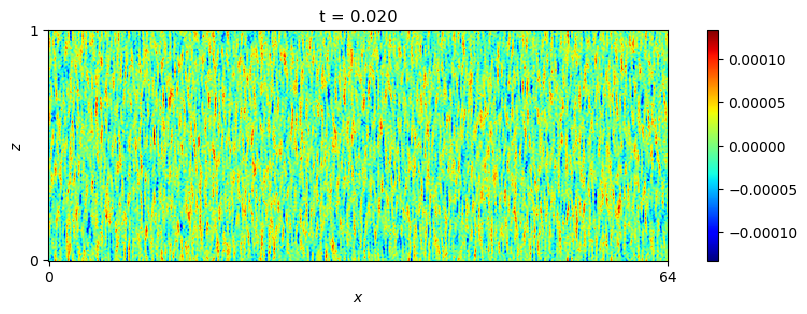

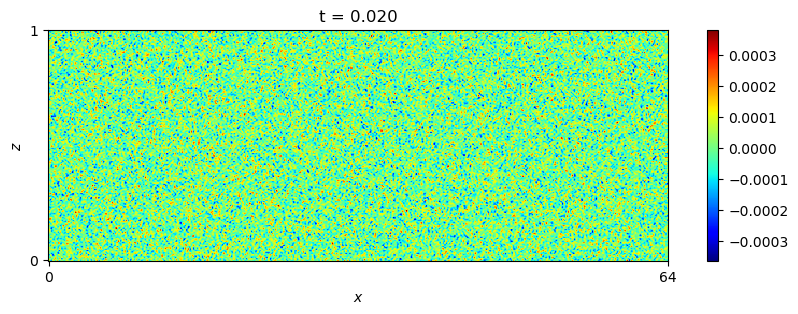

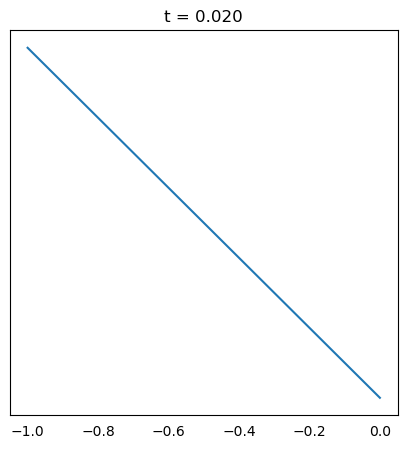

2024-09-30 18:21:39,372 __main__ 0/1 INFO :: Completed iteration 1001, time=20.020, dt=0.0200000000


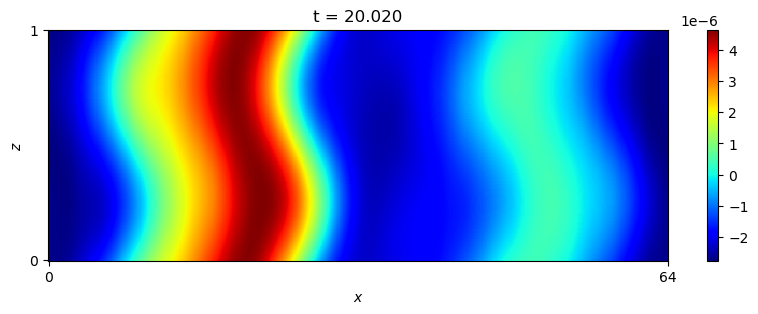

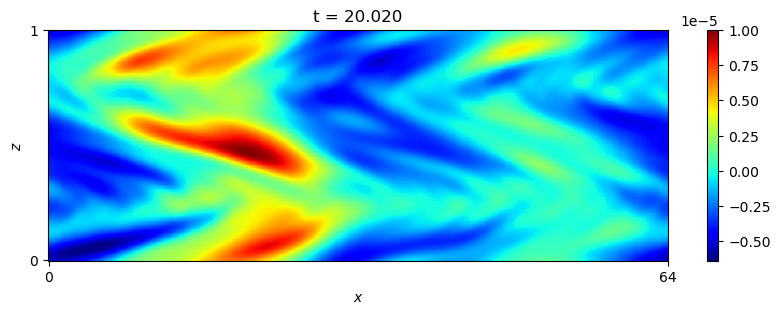

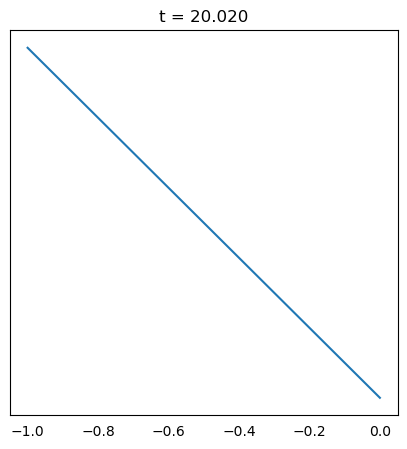

2024-09-30 18:23:43,640 __main__ 0/1 INFO :: Completed iteration 2001, time=40.020, dt=0.0200000000


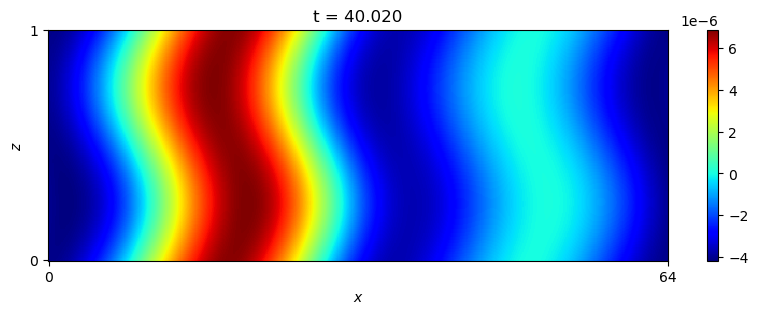

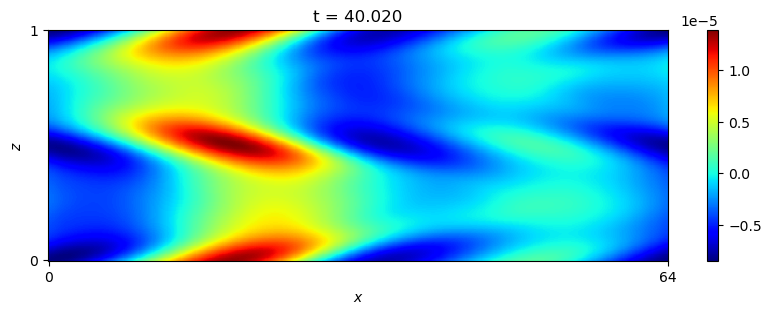

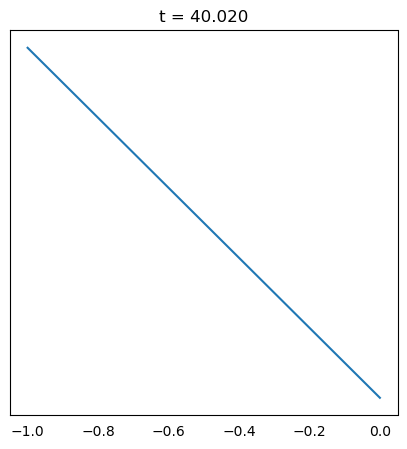

2024-09-30 18:25:46,514 __main__ 0/1 INFO :: Completed iteration 3001, time=60.020, dt=0.0200000000


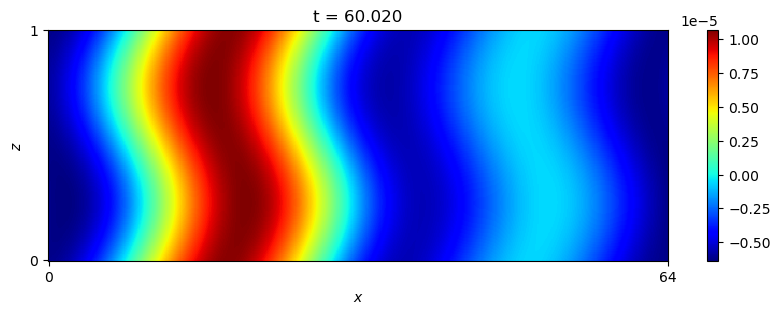

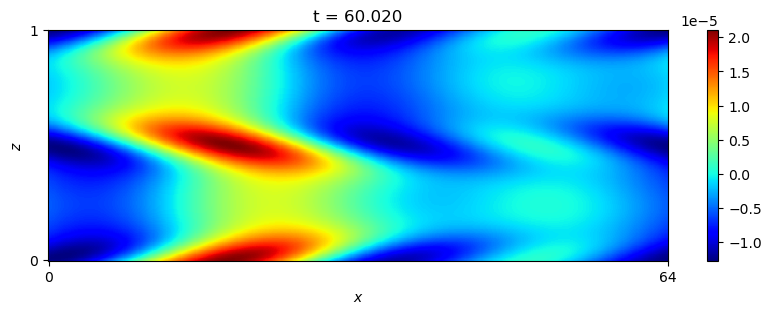

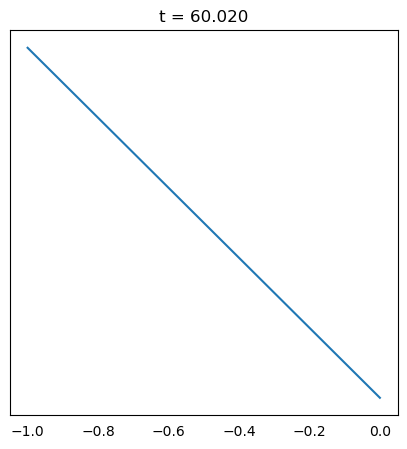

2024-09-30 18:27:45,714 __main__ 0/1 INFO :: Completed iteration 4001, time=80.020, dt=0.0200000000


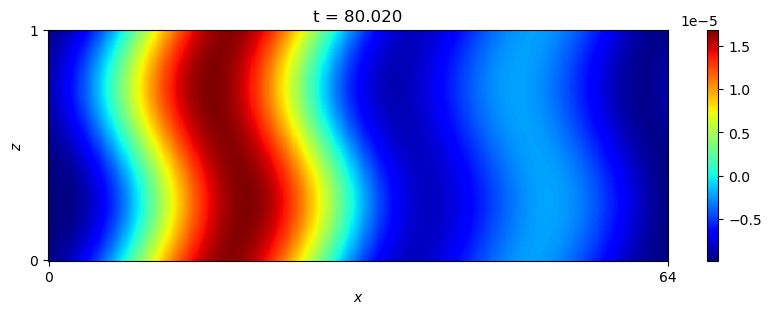

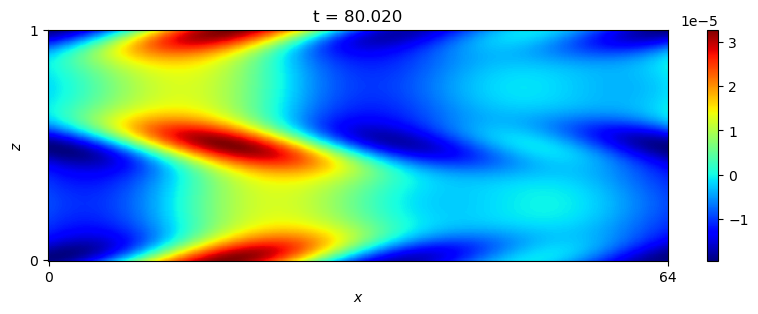

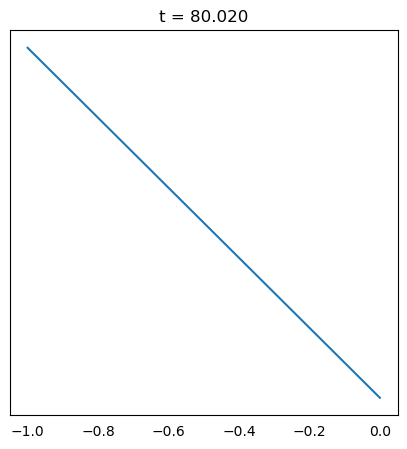

2024-09-30 18:29:48,212 __main__ 0/1 INFO :: Completed iteration 5001, time=100.020, dt=0.0200000000


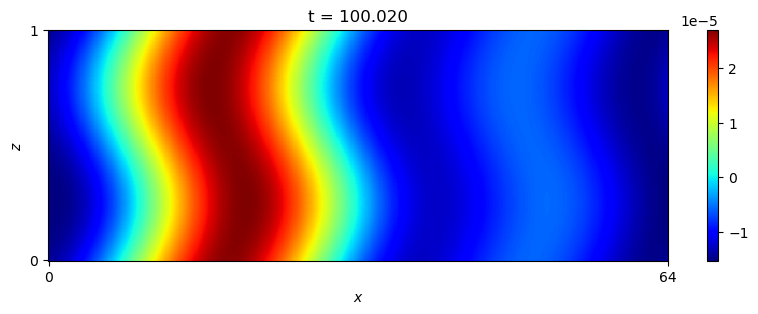

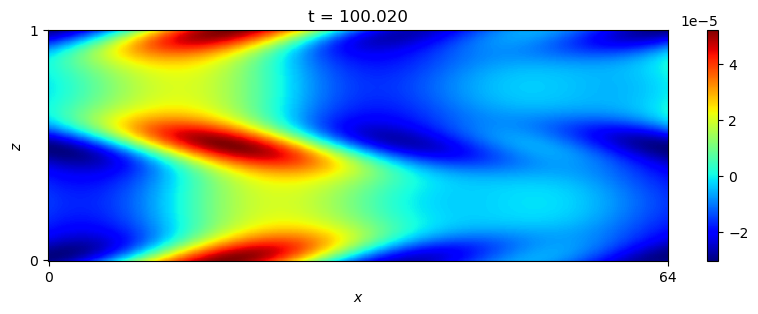

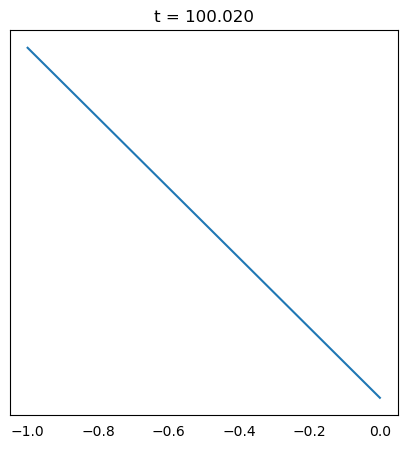

2024-09-30 18:29:48,447 solvers 0/1 INFO :: Simulation stop time reached.
2024-09-30 18:29:48,447 solvers 0/1 INFO :: Final iteration: 5001
2024-09-30 18:29:48,448 solvers 0/1 INFO :: Final sim time: 100.01999999999724
2024-09-30 18:29:48,448 solvers 0/1 INFO :: Setup time (init - iter 0): 3.722 sec
2024-09-30 18:29:48,449 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.56 sec
2024-09-30 18:29:48,449 solvers 0/1 INFO :: Run time (iter 10-end): 608.4 sec
2024-09-30 18:29:48,450 solvers 0/1 INFO :: CPU time (iter 10-end): 0.169 cpu-hr
2024-09-30 18:29:48,450 solvers 0/1 INFO :: Speed: 6.017e+06 mode-stages/cpu-sec


In [59]:

# CFL
CFL = d3.CFL(solver, initial_timestep, cadence=10,
             max_dt=max_timestep,min_dt = 1e-6,
             safety=0.2, threshold=0.1,
             max_change=1.5, min_change=0.5
             )
CFL.add_velocity(U)

xg = xbasis.global_grid(dist, scale=dealias)
zg = zbasis.global_grid(dist, scale=dealias)
# Tmg = Tm.allgather_data('g')

# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)  
        if (solver.iteration-1) % 1000 == 0:
            logger.info('Completed iteration {}, time={:.3f}, dt={:.10f}'.format(solver.iteration, solver.sim_time, timestep))        
            ########################### <--- plot instantaneous temperature distribution
            Tg = Tm.allgather_data('g')+Tp.allgather_data('g')
            Sg = Sm.allgather_data('g')+Sp.allgather_data('g')
            if dist.comm.rank == 0:
                # plot temperature distribution
                plt.figure(figsize=(10,3))
                plt.pcolormesh(xg.ravel(),zg.ravel(),Tg.transpose(),cmap='jet')
                plt.colorbar() 
                plt.xticks([0,Lx])
                plt.yticks([0,Lz])
                plt.xlabel(r'$x$')
                plt.ylabel(r'$z$')
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/T_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
                # plot temperature distribution
                plt.figure(figsize=(10,3))
                plt.pcolormesh(xg.ravel(),zg.ravel(),Sg.transpose(),cmap='jet')
                plt.colorbar() 
                plt.xticks([0,Lx])
                plt.yticks([0,Lz])
                plt.xlabel(r'$x$')
                plt.ylabel(r'$z$')
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/S_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
                # plot horizontaly averaged density profiles
                meanT = np.mean(Tg,axis=0,keepdims=True)
                meanS = np.mean(Sg,axis=0,keepdims=True)
                meanDensity = (meanS-meanT)+(1-Rp)*np.linspace(0,1.,int(Nz*dealias))
                plt.figure(figsize=(5,5))
                plt.plot(np.copy(meanDensity[0]),np.linspace(0,1.,int(Nz*dealias)))
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)# Hide xticks
                plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
                plt.title("t = {:.3f}".format(solver.sim_time))
                plt.show()
                # plt.savefig('snapshots/meanDensity_time={:010.3f}.png'.format(solver.sim_time), bbox_inches='tight')
                plt.close()
            ###########################
            if math.isnan(np.max(Tg)):
                logger.error('NaN values')
                break
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()
